In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time
from patsy import dmatrices
import matplotlib.pyplot as plt

# funciones desarrolladas
from functions.agrupar_dfs_censo import *
from functions.cargar_data import *
from functions.impresion import *

In [2]:
flujos_loc = pd.read_csv('tablas/dd_localidades.csv')
print(flujos_loc.shape[0])
flujos_loc.head(3)

377610


,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m
0,10202220,1020,2220,1304729,40657,635.0,583715
1,10202521,1020,2521,1304729,12200,90.0,612802
2,10202522,1020,2522,1304729,2659,17.0,617076


In [3]:
locs = cargar_datos_geo()[2][['CODLOC', 'geometry']]
locs.head(3)

/home/guillermo/anaconda3/envs/tesis/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,CODLOC,geometry
0,2220,POINT (549273.219 6633915.063)
1,2521,POINT (442454.671 6652273.541)
2,2522,POINT (457921.001 6633361.660)


In [4]:
locs_cod = list(locs.CODLOC)
len(locs_cod) ** 2 - len(locs_cod)

377610

In [5]:
# pega geometrías
dd = flujos_loc.merge(locs, left_on='cod_ori', right_on='CODLOC')
dd = dd.merge(locs, left_on='cod_des', right_on='CODLOC')
dd.drop(['CODLOC_x', 'CODLOC_y'], axis=1, inplace=True)
dd.rename({'geometry_x':'geom_ori', 'geometry_y':'geom_des'}, axis=1, inplace=True)

dd.head()

# exporta CSV con geometrías puntuales para mapa de flujos
#dd.to_csv('capas/loc_lines.csv', index=False)

,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m,geom_ori,geom_des
0,10202220,1020,2220,1304729,40657,635.0,583715,POINT (573082.248 6145008.434),POINT (549273.219 6633915.063)
1,25212220,2521,2220,12200,40657,NaN,137927,POINT (442454.671 6652273.541),POINT (549273.219 6633915.063)
2,25222220,2522,2220,2659,40657,NaN,111408,POINT (457921.001 6633361.660),POINT (549273.219 6633915.063)
3,26212220,2621,2220,2531,40657,NaN,106867,POINT (468458.270 6601361.867),POINT (549273.219 6633915.063)
4,27212220,2721,2220,380,40657,NaN,58392,POINT (502880.928 6648162.053),POINT (549273.219 6633915.063)


In [6]:
print(flujos_loc.shape)
flujos_loc.head()

(377610, 7)


,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m
0,10202220,1020,2220,1304729,40657,635.0,583715
1,10202521,1020,2521,1304729,12200,90.0,612802
2,10202522,1020,2522,1304729,2659,17.0,617076
3,10202621,1020,2621,1304729,2531,9.0,595785
4,10202721,1020,2721,1304729,380,NaN,628213


In [7]:
# reemplaza NaNs de personas migrantes
flujos_loc.loc[flujos_loc.personas_mig.isna(), 'personas_mig'] = 0
flujos_loc['personas_mig'] = flujos_loc['personas_mig'].astype(int)

In [8]:
# convierte códigos a string para ser correctamente interpretados por el modelo
# flujos_loc['cod_ori'] = flujos_loc['cod_ori'].astype(str)
# flujos_loc['cod_des'] = flujos_loc['cod_des'].astype(str)

# flujos_loc_oc = flujos_loc

# flujos_loc_oc.head()

### Zero inflated model

In [9]:
df = flujos_loc
df.head()

,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m
0,10202220,1020,2220,1304729,40657,635,583715
1,10202521,1020,2521,1304729,12200,90,612802
2,10202522,1020,2522,1304729,2659,17,617076
3,10202621,1020,2621,1304729,2531,9,595785
4,10202721,1020,2721,1304729,380,0,628213


In [15]:
expr = "personas_mig ~ cod_ori + np.log(distancia_m) -1"

mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=302230
Testing data set length=75380


In [21]:
# genera las dmatrices de patsy
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [22]:
zip_training_results = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, exog_infl=X_train, inflation='logit').fit()

/home/guillermo/anaconda3/envs/tesis/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/guillermo/anaconda3/envs/tesis/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1090: RuntimeWarning: overflow encountered in exp
  return -np.exp(XB) +  endog*XB - gammaln(endog+1)
/home/guillermo/anaconda3/envs/tesis/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1267: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)
/home/guillermo/anaconda3/envs/tesis/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:861: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred) # not cdf
/home/guillermo/anaconda3/envs/tesis/lib/python3.9/site-packages/statsmodels/discrete/count_model.py:261: RuntimeWarning: invalid value encountered in mul

In [24]:
zip_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:            personas_mig   No. Observations:               302230
Model:             ZeroInflatedPoisson   Df Residuals:                   302228
Method:                            MLE   Df Model:                            1
Date:                 Mon, 03 May 2021   Pseudo R-squ.:                  -1.521
Time:                         18:06:24   Log-Likelihood:            -8.3243e+05
converged:                       False   LL-Null:                   -3.3026e+05
Covariance Type:             nonrobust   LLR p-value:                     1.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_cod_ori                 0.1000     50.685      0.002      0.998     -99.241      99.441
inflate_np.log(distancia_m)     0.1000   3.46e+04   2.89e-06      1.000   -6.79e+04    6.79e+04
cod_ori                        -0.0002   4.55e-06    -34.548      0.000      -0.000      -0.000
np.log(distancia_m)             0.0181      0.003      6.839      0.000       0.013       0.023
===============================================================================================
"""

In [26]:
zip_predictions = zip_training_results.predict(X_test,exog_infl=X_test)
predicted_counts=np.round(zip_predictions)
actual_counts = y_test['personas_mig']


In [27]:
print('ZIP RMSE='+str(
    np.sqrt(
        np.sum(
            np.power(
                np.subtract(predicted_counts,actual_counts),2)))))

ZIP RMSE=3354.6761393612946


In [52]:
# bondad de ajuste

# define una función para calcular el R cuadrado
def calcR2(predicted, actual):
    return np.power(np.corrcoef(actual, predicted),2.0)[0][1]

# define una función para calcula el error medio cuadrático
def calcRMSE(predicted, actual):
    return np.sqrt(np.mean(predicted - actual)**2)

In [56]:
from sklearn.metrics import r2_score

r2_score(actual_counts, predicted_counts)

In [57]:
coefficient_of_dermination

-0.0005517151757632455

In [53]:
printmd('**Bondad de ajuste del modelo restringido en origen**')

printmd("$R²$ = " + round(calcR2(predicted_counts, actual_counts), 4).astype(str))

printmd("RMSE = " + round(calcRMSE(predicted_counts, actual_counts), 4).astype(str))

**Bondad de ajuste del modelo restringido en origen**

/home/guillermo/anaconda3/envs/tesis/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/guillermo/anaconda3/envs/tesis/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


$R²$ = nan

RMSE = 0.2869

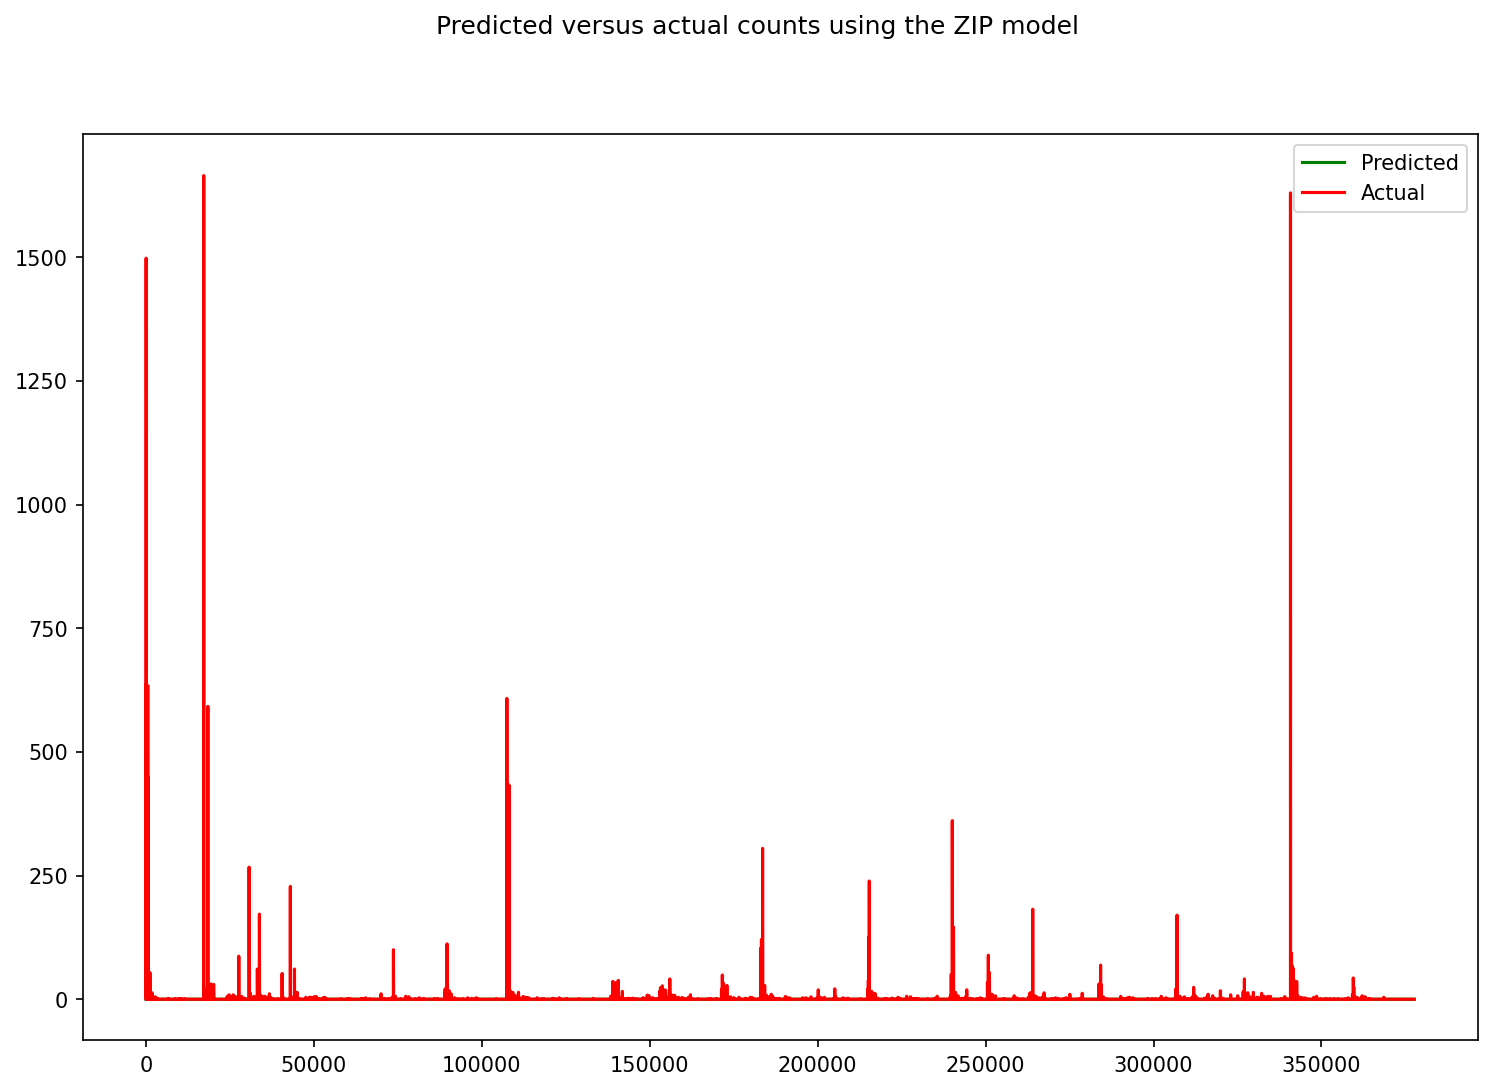

In [34]:
# gráfica
fig = plt.figure(figsize=(12, 8), dpi=150)

fig.suptitle('Predicted versus actual counts using the ZIP model')

predicted, = plt.plot(X_test.index, predicted_counts, 'g', label='Predicted')

actual, = plt.plot(X_test.index, actual_counts, 'r', label='Actual')

plt.legend(handles=[predicted, actual])

plt.show()